### Wczytywanie bibliotek, metod, narzędzi

In [1]:
# w związku z próbowaniem różnych metod/modeli, które nie zawsze ostały sie w finalnym projekcie 
# może być importowane więcej niż potrzebne. 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import tensorflow as tf
import random

from matplotlib import image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

from PIL import Image
%matplotlib inline

### Ustawianie stałych, inicjowanie gromadzenia wyników

In [2]:
data_dir = 'images selected'
img_width = 224
img_height = 224


names = []   # będzie zbierała nazwy różnych modeli do porównania
accuracy_train = []  # będzie zbierała wyniki accuracy na zbiorze treningowym
accuracy_test = [] # będzie zbierała wyniki accuracy na zbiorze testowym

### Wczytywanie danych

In [3]:
# wczytywanie zbioru obrazów wraz ze zmianą kształtu i konwertowaniu wartości do przedziału (o,1)

def create_dataset(data_dir):
    
    img_data = [] # nasz zbior obrazow
    class_name = [] #zbior nazw ras
    for dir1 in os.listdir(data_dir): #przechodzimy po kazdym katalogu
        for file in os.listdir(os.path.join(data_dir, dir1)): # i po kazdym obrazku
               
            image_path= os.path.join(data_dir, dir1,  file)
            image = Image.open(image_path)
            image = image.resize((img_height,img_width)) # zmieniamy rozmiar obrazka
            image = np.array(image) # zamieniamy na tablicę numpy
            image = image.astype('float32')
            image /= 255    #skalowanie do przedzialu 0-1
            
            img_data.append(image)
            class_name.append(re.sub("n02[\w]*-", '', dir1)) #nazwa rasy po usunięciu odnośnika do katalogu
    return img_data, class_name

PIL_img_data, class_name = create_dataset(data_dir)

target_dict={k: v for v, k in enumerate(np.unique(class_name))} #nadawanie labeli numerycznych nazwom psów
target_val=  [target_dict[class_name[i]] for i in range(len(class_name))] #tworzenie numerycznego target

X = np.array(PIL_img_data) #konwertowanie do np.array by móc uczyć model
y = np.array(target_val) #konwertowanie do np.array by móc uczyć model

### Podział na zbiory train i test. Prezentacja losowego obrazka z opisem

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# Podstawowe statystyki danych
print('Mamy %d ras psów.' % len(np.unique(class_name)))
print('Uczymy modele na %d obrazkach.' % len(X_train))
print('A testujemy na %d obrazkach.'% len(X_test))

Mamy 10 ras psów.
Uczymy modele na 1737 obrazkach.
A testujemy na 193 obrazkach.


Blenheim_spaniel


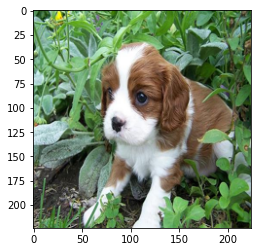

In [8]:
#na poprawę humoru rysowanie losowego pieska i zwracanie jego nazwy ze słownika

num = random.randint(0,len(X_train))

plt.imshow(X_train[num])

for name, number in target_dict.items():  
    if number == y_train[num]:
        print(name)
        

# Uczenie modeli

### Tworzenie sieci konwolucyjnej od podstaw (nie bazującej na nauczonym wczesniej modelu)

#### Wersja 1

Definiowanie modelu

In [9]:
model_CNN = Sequential()

model_CNN.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(img_height, img_width, 3)))
model_CNN.add(MaxPooling2D(pool_size=2))

model_CNN.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=2))

model_CNN.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=2))

model_CNN.add(Dropout(0.4))
model_CNN.add(Flatten())
model_CNN.add(Dense(512, activation='relu'))
model_CNN.add(Dropout(0.4))
model_CNN.add(Dense(10, activation='softmax'))

model_CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 64)        0

In [10]:
model_CNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Uczenie modelu

In [11]:
es = EarlyStopping(patience=5) #zastosowanie early stoppping

model_CNN.fit(X_train, y_train, epochs=100,callbacks=[es], validation_split=0.15)

Epoch 1/100
47/47 [==============================] - 43s 909ms/step - loss: 2.7607 - accuracy: 0.1457 - val_loss: 2.2441 - val_accuracy: 0.1762
Epoch 2/100
47/47 [==============================] - 42s 887ms/step - loss: 2.0770 - accuracy: 0.2595 - val_loss: 2.1038 - val_accuracy: 0.2567
Epoch 3/100
47/47 [==============================] - 42s 894ms/step - loss: 1.8952 - accuracy: 0.3367 - val_loss: 1.9744 - val_accuracy: 0.2874
Epoch 4/100
47/47 [==============================] - 40s 860ms/step - loss: 1.6049 - accuracy: 0.4607 - val_loss: 1.9681 - val_accuracy: 0.3180
Epoch 5/100
47/47 [==============================] - 34s 717ms/step - loss: 1.3254 - accuracy: 0.5569 - val_loss: 1.9471 - val_accuracy: 0.3257
Epoch 6/100
47/47 [==============================] - 34s 723ms/step - loss: 0.9574 - accuracy: 0.7005 - val_loss: 2.1158 - val_accuracy: 0.3755
Epoch 7/100
47/47 [==============================] - 35s 747ms/step - loss: 0.6214 - accuracy: 0.8171 - val_loss: 2.4326 - val_accuracy:

Wyznaczanie model accuracy

In [12]:
y_pred_train = np.argmax(model_CNN.predict(X_train), axis=1)
y_pred_test = np.argmax(model_CNN.predict(X_test), axis=1)

acc_train = accuracy_score(y_train,y_pred_train)
acc_test = accuracy_score(y_test,y_pred_test)
name = 'CNN version 1 without data augmentation'

names.append(name)
accuracy_train.append(acc_train)
accuracy_test.append(acc_test)

print('%s ma accuracy' % name, 'na probie uczacej równe %f' %acc_train, 'a na próbie testowej wynosi %f.' % acc_test)

CNN version 1 without data augmentation ma accuracy na probie uczacej równe 0.894070 a na próbie testowej wynosi 0.393782.


#### Wersja 2

Definiowanie modelu

In [13]:
model_CNN2 = Sequential()

model_CNN2.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(img_height, img_width, 3)))
model_CNN2.add(MaxPooling2D(pool_size=(3, 3)))

model_CNN2.add(Conv2D(64, (3, 3), activation='relu'))
model_CNN2.add(MaxPooling2D(pool_size=(2, 2)))

model_CNN2.add(Dropout(0.25))
model_CNN2.add(Flatten())
model_CNN2.add(Dense(128, activation='relu'))
model_CNN2.add(Dropout(0.5))
model_CNN2.add(Dense(10, activation='softmax'))

model_CNN2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 82944)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

In [14]:
model_CNN2.compile(optimizer='RMSprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Uczenie modelu

In [15]:
es = EarlyStopping(patience=5) #zastosowanie early stoppping

model_CNN2.fit(X_train, y_train, epochs=100,callbacks=[es], validation_split=0.15)

Epoch 1/100
47/47 [==============================] - 45s 961ms/step - loss: 3.1099 - accuracy: 0.1199 - val_loss: 2.3431 - val_accuracy: 0.0728
Epoch 2/100
47/47 [==============================] - 46s 984ms/step - loss: 2.2666 - accuracy: 0.1673 - val_loss: 2.2571 - val_accuracy: 0.1877
Epoch 3/100
47/47 [==============================] - 37s 788ms/step - loss: 2.0980 - accuracy: 0.2636 - val_loss: 2.8367 - val_accuracy: 0.1571
Epoch 4/100
47/47 [==============================] - 37s 788ms/step - loss: 1.8698 - accuracy: 0.3584 - val_loss: 2.3428 - val_accuracy: 0.2375
Epoch 5/100
47/47 [==============================] - 37s 793ms/step - loss: 1.5745 - accuracy: 0.4641 - val_loss: 2.0543 - val_accuracy: 0.3180
Epoch 6/100
47/47 [==============================] - 37s 793ms/step - loss: 1.2577 - accuracy: 0.5860 - val_loss: 2.0249 - val_accuracy: 0.3103
Epoch 7/100
47/47 [==============================] - 38s 803ms/step - loss: 0.9328 - accuracy: 0.7019 - val_loss: 2.7621 - val_accuracy:

Wyznaczanie model accuracy

In [16]:
y_pred_train = np.argmax(model_CNN2.predict(X_train), axis=1)
y_pred_test = np.argmax(model_CNN2.predict(X_test), axis=1)

acc_train = accuracy_score(y_train,y_pred_train)
acc_test = accuracy_score(y_test,y_pred_test)
name = 'CNN version 2 without data augmentation'

names.append(name)
accuracy_train.append(acc_train)
accuracy_test.append(acc_test)

print('%s ma accuracy' % name, 'na probie uczacej równe %f' %acc_train, 'a na próbie testowej wynosi %f.' % acc_test)

CNN version 2 without data augmentation ma accuracy na probie uczacej równe 0.872193 a na próbie testowej wynosi 0.352332.


### Uczenie tradycyjnej sieci neuronowej

Definiowanie modelu

In [17]:
X_tn = X_train.reshape(len(X_train), -1)# splaszczanie danych by móc wstawić do siecie neuronowej zwykłej
X_ts = X_test.reshape(len(X_test), -1)# splaszczanie danych

#nie stosuje GridSearch bo za wolno się liczy, ale przykładowo

#params = {
#    'mlpclassifier__hidden_layer_sizes': [10,  30, (5, 5), (20, 20)],
#    'mlpclassifier__activation': ['relu', 'tanh']
#}

#pipe = make_pipeline(StandardScaler(),
      #              MLPClassifier(early_stopping=True, 
        #                         validation_fraction=0.15, 
          #                       n_iter_no_change=5,
           #                      max_iter=10000,
            #                     tol=0))

#grid = GridSearchCV(estimator=pipe,
 #                  param_grid=params,
    #               n_jobs=-1,
     #              cv=5, 
      #             verbose=1)
#grid.fit(X_tn, y_train)           

#definiowanie pipeline
model_MLPC = make_pipeline(StandardScaler(), 
                          MLPClassifier(hidden_layer_sizes=10, 
                                        max_iter=10000, 
                                        tol=0, 
                                        activation='tanh',
                                        early_stopping=True,
                                        validation_fraction=0.15,
                                        n_iter_no_change=5))


Uczenie modelu

In [18]:
model_MLPC.fit(X_tn, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(activation='tanh', early_stopping=True,
                               hidden_layer_sizes=10, max_iter=10000,
                               n_iter_no_change=5, tol=0,
                               validation_fraction=0.15))])

Wyznaczanie model accuracy

In [19]:
acc_train = accuracy_score(y_train, model_MLPC.predict(X_tn))
acc_test = accuracy_score(y_test, model_MLPC.predict(X_ts))

name = 'MLPC without data augmentation'

names.append(name)
accuracy_train.append(acc_train)
accuracy_test.append(acc_test)

print('%s ma accuracy' % name, 'na probie uczacej równe %f' %acc_train, 'a na próbie testowej wynosi %f.' % acc_test)

MLPC without data augmentation ma accuracy na probie uczacej równe 0.179620 a na próbie testowej wynosi 0.139896.


### Tworzenie sieci konwolucyjnej na bazie nauczonego juz modelu z data augmentation

#### Model oparty na VGG19

Definiowanie modelu

In [20]:
base_model_VGG19 = VGG19(weights='imagenet', include_top=False, input_shape=(img_height,img_width,3))

top_model_VGG19 = Sequential()
                           
top_model_VGG19.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
top_model_VGG19.add(MaxPooling2D(pool_size=(2, 2)))

top_model_VGG19.add(Dropout(0.25))

top_model_VGG19.add(Flatten())
top_model_VGG19.add(Dense(128, activation='relu'))
top_model_VGG19.add(Dropout(0.5)) #by uniknąć przetrenowania stosujemy Dropout
top_model_VGG19.add(Dense(10, activation='softmax'))

model_VGG19 = Sequential()
model_VGG19.add(base_model_VGG19)
model_VGG19.add(top_model_VGG19)

In [21]:
model_VGG19.layers[0].trainable = False # zamrażamy wszystkie wagi VGG19

In [22]:
model_VGG19.compile(loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy']) 

Uczenie modelu

In [23]:
epochs = 50
batch_size = 10
nb_train_samples = 1563 # możemy zwiększyć tą liczbę obrazów zaugmentowanych 
nb_validation_samples = 174


# prepare data augmentation configuration
train_datagen = ImageDataGenerator(shear_range=0.2, 
                                   zoom_range=0.2,
                                   rotation_range=30, 
                                   horizontal_flip=True,
                                   vertical_flip=True)
test_datagen = ImageDataGenerator()

#ponieważ nie mam zbioru walidacyjnego, a nie chce używać zbioru test podczas nauki, wydzielam zbiór walidacyjny
X_tn, X_val, y_tn, y_val = train_test_split(X_train, y_train, test_size=0.1)


train_generator = train_datagen.flow(X_tn, y_tn,
                                     batch_size=batch_size)

validation_generator = test_datagen.flow(X_val,y_val,
                                    batch_size=batch_size)


model_VGG19.fit_generator(train_generator, steps_per_epoch=nb_train_samples/batch_size, validation_data=validation_generator,
              validation_steps=nb_validation_samples/batch_size,
             epochs=epochs)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
157/156 [==============================] - 516s 3s/step - loss: 2.3599 - accuracy: 0.1222 - val_loss: 2.2659 - val_accuracy: 0.1954
Epoch 2/50
157/156 [==============================] - 512s 3s/step - loss: 2.2533 - accuracy: 0.1881 - val_loss: 2.1258 - val_accuracy: 0.1724
Epoch 3/50
157/156 [==============================] - 514s 3s/step - loss: 2.1553 - accuracy: 0.2316 - val_loss: 1.9644 - val_accuracy: 0.3218
Epoch 4/50
157/156 [==============================] - 402s 3s/step - loss: 2.0587 - accuracy: 0.2578 - val_loss: 1.6725 - val_accuracy: 0.4080
Epoch 5/50
157/156 [==============================] - 390s 2s/step - loss: 1.9060 - accuracy: 0.3231 - val_loss: 1.6094 - val_accuracy: 0.4023
Epoch 6/50
157/156 [==============================] - 468s 3s/step - loss: 1.8705 - accuracy: 0.3378 - val_loss: 1.6482 - val_accuracy: 0.3966
Epoch 7/50
157/156 [==============================] - 512s 3s/step

Wyznaczanie model accuracy

In [26]:
y_pred_train = np.argmax(model_VGG19.predict(X_train), axis=1)
y_pred_test = np.argmax(model_VGG19.predict(X_test), axis=1)

acc_train = accuracy_score(y_train,y_pred_train)
acc_test = accuracy_score(y_test,y_pred_test)

name = 'CRR oparta na VGG19 with data augmentation'

names.append(name)
accuracy_train.append(acc_train)
accuracy_test.append(acc_test)

print('%s ma accuracy' % name, 'na probie uczacej równe %f' %acc_train, 'a na próbie testowej wynosi %f.' % acc_test)

CRR oparta na VGG19 with data augmentation ma accuracy na probie uczacej równe 0.562464 a na próbie testowej wynosi 0.528497.


### Dodanie augemacji danych do uczenia pierwszego modelu

Definiowanie generatora

In [42]:
train_datagen = ImageDataGenerator(shear_range=0.2, 
                                   zoom_range=0.2,
                                   rotation_range=30, 
                                   horizontal_flip=True,
                                   vertical_flip=True)
test_datagen = ImageDataGenerator()

#ponieważ nie mam zbioru walidacyjnego, a nie chce używać zbioru test podczas nauki, wydzielam zbiór walidacyjny
X_tn, X_val, y_tn, y_val = train_test_split(X_train, y_train, test_size=0.1)

#### Wersja 1 modelu

Uczenie pierwszej wersji modelu z wzbogadzeniem danych

In [46]:
epochs = 50
batch_size = 10
nb_train_samples = 1563 # możemy zwiększyć tą liczbę obrazów zaugmentowanych 
nb_validation_samples = 174

model_CNN.fit_generator(train_datagen.flow(X_train,y_train,batch_size=batch_size, shuffle=False), 
                        steps_per_epoch=nb_train_samples/batch_size, 
                        validation_data=test_datagen.flow(X_val,y_val, batch_size=batch_size, shuffle=False),
                        validation_steps=nb_validation_samples/batch_size,
                        epochs=epochs)

Epoch 1/50
157/156 [==============================] - 66s 419ms/step - loss: 1.6914 - accuracy: 0.4040 - val_loss: 1.6199 - val_accuracy: 0.4138
Epoch 2/50
157/156 [==============================] - 58s 371ms/step - loss: 1.7117 - accuracy: 0.4083 - val_loss: 1.5077 - val_accuracy: 0.4368
Epoch 3/50
157/156 [==============================] - 60s 384ms/step - loss: 1.6921 - accuracy: 0.3918 - val_loss: 1.4836 - val_accuracy: 0.4828
Epoch 4/50
157/156 [==============================] - 60s 383ms/step - loss: 1.6655 - accuracy: 0.4078 - val_loss: 1.4553 - val_accuracy: 0.5402
Epoch 5/50
157/156 [==============================] - 59s 378ms/step - loss: 1.6657 - accuracy: 0.4071 - val_loss: 1.4961 - val_accuracy: 0.4770
Epoch 6/50
157/156 [==============================] - 67s 425ms/step - loss: 1.6321 - accuracy: 0.4193 - val_loss: 1.4515 - val_accuracy: 0.5115
Epoch 7/50
157/156 [==============================] - 65s 412ms/step - loss: 1.6138 - accuracy: 0.4486 - val_loss: 1.4771 - val_ac

Wyznaczanie model accuracy

In [47]:
y_pred_train = np.argmax(model_CNN.predict(X_train), axis=1)
y_pred_test = np.argmax(model_CNN.predict(X_test), axis=1)

acc_train = accuracy_score(y_train,y_pred_train)
acc_test = accuracy_score(y_test,y_pred_test)
name = 'CNN version 1 with data augmentation'

names.append(name)
accuracy_train.append(acc_train)
accuracy_test.append(acc_test)

print('%s ma accuracy' % name, 'na probie uczacej równe %f' %acc_train, 'a na próbie testowej wynosi %f.' % acc_test)

CNN version 1 with data augmentation ma accuracy na probie uczacej równe 0.694301 a na próbie testowej wynosi 0.450777.


### Prezentowanie wyników wszystkich metod

In [48]:
df = pd.DataFrame({'Accuracy train' : accuracy_train, 'Accuracy test' : accuracy_test}, index=names) 

print(df)

                                            Accuracy train  Accuracy test
CNN version 1 without data augmentation           0.894070       0.393782
CNN version 2 without data augmentation           0.872193       0.352332
MLPC without data augmentation                    0.179620       0.139896
CRR oparta na VGG19 with data augmentation        0.562464       0.528497
CNN version 1 with data augmentation              0.694301       0.450777


Z zaprezentowanych wyników widać, że sieci uczone bez augmentacji danych, mimo większego accuracy na zbiorze uczącym, to ich działania na zbiorze testowym bardzo spadało. Najstabilniejsze statystyki otrzymane były w modelu opartym o VGG19, nauka tych modeli była także najdłuzsza.